# Random Forest (Expanded Features) — ACS Poverty Risk

In [1]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


## 1) Load data

In [2]:
import joblib
import pandas as pd
from scipy import sparse
from pathlib import Path

data_dir = Path("../3_Data_Preprocessing/preprocessing_data")

X_train_sparse = sparse.load_npz(data_dir / "X_train_sparse_rf.npz")
X_test_sparse = sparse.load_npz(data_dir / "X_test_sparse_rf.npz")

y_train = pd.read_csv(data_dir / "y_train_rf.csv").squeeze()
y_test = pd.read_csv(data_dir / "y_test_rf.csv").squeeze()

preprocessor = joblib.load(data_dir / "rf_preprocessor.joblib")

## 2) Train Random Forest (using balanced subsample)

In [3]:

rf_bss = RandomForestClassifier(
    n_estimators=400,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced_subsample", # set to account for class imbalance in povpip
    random_state=42,
    n_jobs=-1
)

rf_bss.fit(X_train_sparse, y_train)

y_pred_bss = rf_bss.predict(X_test_sparse)

print("=== Random Forest Performance ===")
print(classification_report(y_test, y_pred_bss))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_bss))


=== Random Forest Performance ===
              precision    recall  f1-score   support

           0       0.92      0.68      0.78    233793
           1       0.24      0.42      0.30     38456
           2       0.16      0.25      0.19     15534
           3       0.23      0.57      0.33     16585

    accuracy                           0.62    304368
   macro avg       0.39      0.48      0.40    304368
weighted avg       0.76      0.62      0.67    304368

Confusion matrix:
[[158244  43965  12127  19457]
 [  9512  16078   5827   7039]
 [  2623   4780   3909   4222]
 [  1855   2610   2707   9413]]


In [4]:
# NOTE ON CLASS IMBALANCE HANDLING (balanced_subsample)
# ----------------------------------------------------
# We use class_weight="balanced_subsample" to address class imbalance in the poverty_risk_score labels.
# Random Forest trains each tree on a *bootstrap sample* of the training data (a resampled subset).
# With "balanced_subsample", sklearn recomputes class weights *separately for each tree* based on that
# tree’s bootstrap sample class distribution.
#
# Strengths:
# - More robust when bootstrap samples have slightly different class proportions (weights adapt per tree).
# - Often a bit more stable / less aggressive than global reweighting, reducing the risk of over-correcting.
# - Can work well when you want imbalance handling but still want the forest to reflect natural variation
#   across bootstrap samples.
#
# Weaknesses / tradeoffs:
# - Because weights vary per tree and can be less aggressive overall, minority-class precision/recall gains
#   may be smaller than with global "balanced".
# - If minority classes are *consistently* under-predicted, this approach may not push the model enough.
#
# Practical expectation:
# - Tends to improve minority sensitivity compared to no weighting, while being somewhat conservative.


## 3) Train Random Forest (using "balanced")

In [5]:
# ---- Random Forest with class_weight="balanced" ----

rf_bal = RandomForestClassifier(
    n_estimators=400,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",   # changed from "balanced_subsample"
    random_state=42,
    n_jobs=-1
)

rf_bal.fit(X_train_sparse, y_train)

y_pred_bal = rf_bal.predict(X_test_sparse)

print("=== Random Forest Performance (class_weight='balanced') ===")
print(classification_report(y_test, y_pred_bal))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_bal))


=== Random Forest Performance (class_weight='balanced') ===
              precision    recall  f1-score   support

           0       0.92      0.68      0.78    233793
           1       0.24      0.42      0.30     38456
           2       0.16      0.25      0.20     15534
           3       0.23      0.57      0.33     16585

    accuracy                           0.62    304368
   macro avg       0.39      0.48      0.40    304368
weighted avg       0.76      0.62      0.67    304368

Confusion matrix:
[[158168  43972  12058  19595]
 [  9481  16120   5832   7023]
 [  2614   4778   3934   4208]
 [  1859   2604   2751   9371]]


In [6]:
# NOTE ON CLASS IMBALANCE HANDLING (balanced)
# ------------------------------------------
# We use class_weight="balanced" to address class imbalance in the poverty_risk_score labels.
# With "balanced", sklearn computes class weights *once* from the full training set:
#   weight_c = n_samples / (n_classes * n_samples_in_class_c)
# These fixed weights are then applied consistently across all trees in the forest.
#
# Strengths:
# - More direct / stronger correction for class imbalance than "balanced_subsample".
# - Can improve minority-class performance (often macro F1, sometimes minority precision) because minority
#   errors are penalized more uniformly across the whole forest.
# - Easier to reason about and reproduce because weights do not vary tree-to-tree.
#
# Weaknesses / tradeoffs:
# - Can reduce majority-class recall and sometimes overall accuracy (common when shifting focus to minorities).
# - If the true signal separating minority classes is weak, stronger weighting may increase false positives
#   (e.g., predicting higher poverty risk more often).
#
# Practical expectation:
# - Often boosts minority recall/precision somewhat, but may trade off performance on the majority class.


## 5) Visualizations of Model Performance

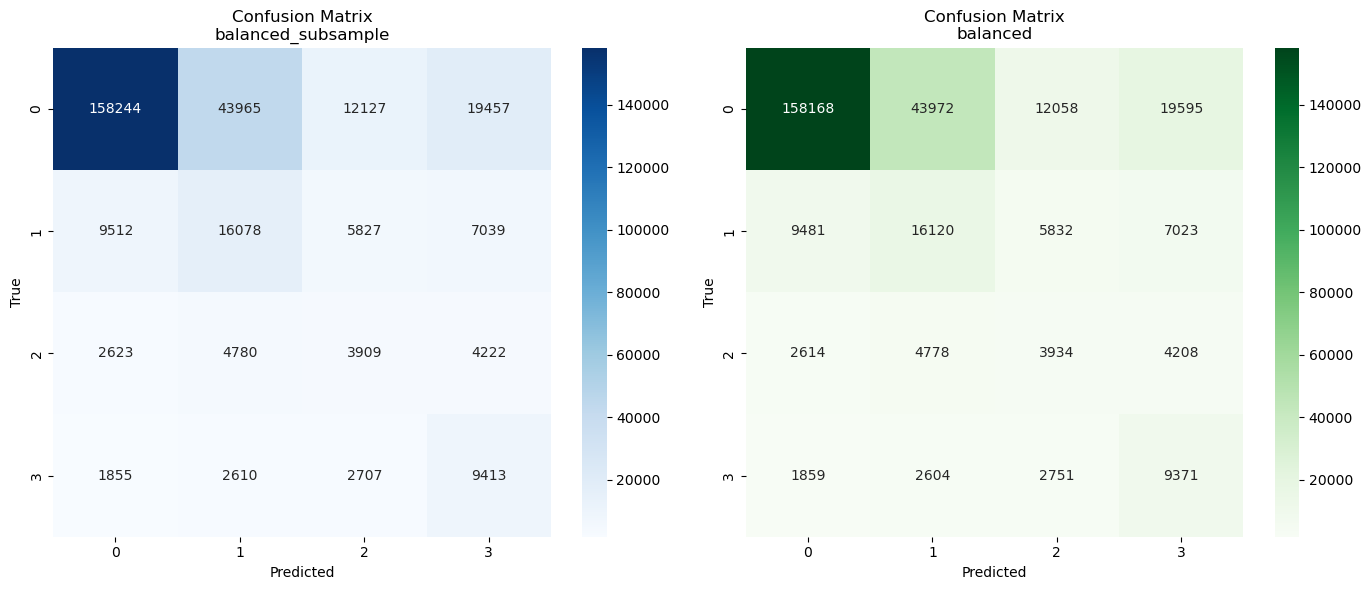

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_sub = confusion_matrix(y_test, y_pred_bss)
cm_bal = confusion_matrix(y_test, y_pred_bal)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_sub, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix\nbalanced_subsample")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Confusion Matrix\nbalanced")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
from sklearn.metrics import classification_report

report_sub = classification_report(y_test, y_pred_bss, output_dict=True)
report_bal = classification_report(y_test, y_pred_bal, output_dict=True)

rows = []

for c in ["0", "1", "2", "3"]:
    rows.append({
        "class": c,
        "precision_subsample": report_sub[c]["precision"],
        "precision_balanced": report_bal[c]["precision"],
        "recall_subsample": report_sub[c]["recall"],
        "recall_balanced": report_bal[c]["recall"],
        "f1_subsample": report_sub[c]["f1-score"],
        "f1_balanced": report_bal[c]["f1-score"],
    })

df_compare = pd.DataFrame(rows)
df_compare


,class,precision_subsample,precision_balanced,recall_subsample,recall_balanced,f1_subsample,f1_balanced
0,0,0.918773,0.918930,0.676855,0.676530,0.779475,0.779316
1,1,0.238429,0.238907,0.418088,0.419180,0.303676,0.304352
2,2,0.159096,0.160081,0.251642,0.253251,0.194943,0.196165
3,3,0.234557,0.233127,0.567561,0.565029,0.331935,0.330069


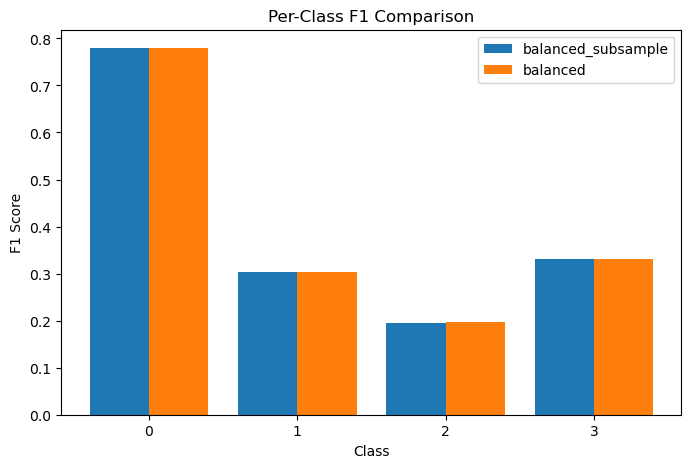

In [10]:
import matplotlib.pyplot as plt

x = range(len(df_compare))

plt.figure(figsize=(8,5))
plt.bar([i-0.2 for i in x], df_compare["f1_subsample"], width=0.4, label="balanced_subsample")
plt.bar([i+0.2 for i in x], df_compare["f1_balanced"], width=0.4, label="balanced")

plt.xticks(x, df_compare["class"])
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Comparison")
plt.legend()
plt.show()


In [11]:
print("Macro F1 (subsample):", report_sub["macro avg"]["f1-score"])
print("Macro F1 (balanced) :", report_bal["macro avg"]["f1-score"])

print("Weighted F1 (subsample):", report_sub["weighted avg"]["f1-score"])
print("Weighted F1 (balanced) :", report_bal["weighted avg"]["f1-score"])


Macro F1 (subsample): 0.40250736172605994
Macro F1 (balanced) : 0.40247565861998447
Weighted F1 (subsample): 0.6651403012202687
Weighted F1 (balanced) : 0.6650639592056318


In [ ]:
#Citations to investigate
#Anisha, S. S., Nargunam, A. S., & Shameem, M. (2024). Machine Learning Methods to Predict and Classify Poverty. In Smart Technologies for Sustainable Development Goals (pp. 159-177). CRC Press.
#Hindman, M. (2015). Building better models: Prediction, replication, and machine learning in the social sciences. The Annals of the American Academy of Political and Social Science, 659(1), 48-62.
#Venkatramolla, S. K. (2019). Machine learning and data science for a household-specific poverty level prediction task.

In [14]:
import pandas as pd
import numpy as np
import json
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load engineered data
df_train = pd.read_csv('../3_Data_Preprocessing/preprocessing_data/train_engineered.csv')
df_test  = pd.read_csv('../3_Data_Preprocessing/preprocessing_data/test_engineered.csv')

# Load metadata
with open('../3_Data_Preprocessing/preprocessing_data/feature_engineering_metadata.json', 'r') as f:
    metadata = json.load(f)

all_features = metadata['all_features']
optimal_features = metadata.get('optimal_features', all_features)  # fallback if missing

# Prepare X, y
X_train = df_train[all_features].copy()
y_train = df_train['binary_target'].copy()
X_test  = df_test[all_features].copy()
y_test  = df_test['binary_target'].copy()

# Optional: use reduced/optimal set
X_train_final = df_train[optimal_features].copy()
X_test_final  = df_test[optimal_features].copy()

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_train_final (optimal): {X_train_final.shape}')
print(f'X_test:  {X_test.shape}, y_test:  {y_test.shape}')
print(f'y_train distribution: {Counter(y_train)}')
print(f'y_test distribution:  {Counter(y_test)}')

# --- Safety check: ensure all features are numeric ---
non_numeric = X_train_final.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    raise ValueError(
        f"Found non-numeric columns in engineered features: {non_numeric[:10]} "
        f"{'(and more...)' if len(non_numeric) > 10 else ''}. "
        "These must be encoded before fitting RandomForest."
    )

# Train Random Forest on engineered features
rf_eng = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"  # good default for imbalance
)

rf_eng.fit(X_train_final, y_train)

y_pred = rf_eng.predict(X_test_final)

print("\nRandom Forest on engineered features (optimal_features):")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

FileNotFoundError: [Errno 2] No such file or directory: '../3_Data_Preprocessing/preprocessing_data/train_engineered.csv'